## NYC Taxi Fare Prediction ##

### Part 1: Import and Set Data ###

In [1]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import calendar
from math import sin, cos, sqrt, atan2, radians,asin
import matplotlib.dates as mdates
import matplotlib as mpl
from datetime import timedelta
import datetime as dt
from taxi_functions import distance, boundaryBox, isLocation

% matplotlib inline
plt.style.use('seaborn-whitegrid')

We will start by uploading a portion of the train dataset to explore. The full dataset consists of ~55M samples. We will begin with 15M. 

In [2]:
import time
# import training data
start_time = time.time() # track time
train_df =  pd.read_csv('all/train.csv', nrows=15000000) 
print("%s seconds" % (time.time() - start_time))

# insert testing data
start_time = time.time() # track time
test_df =  pd.read_csv('all/test.csv')
print("%s seconds" % (time.time() - start_time))

58.04833912849426 seconds
0.04163312911987305 seconds


In [3]:
# list first few rows
display(train_df.head(n=5))

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [4]:
display(test_df.head(n=5))

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


Let's examine what datatypes we'll be working with:

In [5]:
print(train_df.dtypes)
print(test_df.dtypes)

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object
key                   object
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object


#### Explore the Test Data ####

In [6]:
#check null value
print(test_df.isnull().sum())
#check zero value
print((test_df == 0).astype(int).sum(axis=0))

key                  0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64
key                  0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


In [7]:
test_df.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


Test data is very clean.

#### Explore the Train Data ####

In [8]:
#check null value 
print(train_df.isnull().sum())
#check zero value 
print((train_df == 0).astype(int).sum(axis=0))
# There are some null and zero values in the train data. This step is very import, 
# as these values can influence the training result significantly

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    99
dropoff_latitude     99
passenger_count       0
dtype: int64
key                       0
fare_amount             400
pickup_datetime           0
pickup_longitude     285502
pickup_latitude      284597
dropoff_longitude    284772
dropoff_latitude     283939
passenger_count       52876
dtype: int64


A few observations from the data description:

* The minimum of the ```fare_amount``` feature is negative. As this is not realistic, I will drop those samples from the dataset.
* Some of the longitude/latitude coordinates are way off. We'll make a bounding box later based on the test data and drop those as well.
* The only feature we don't have boundaries for is fare_amount. Let's look at the distribution.

In [9]:
train_df[['fare_amount']].quantile([0.001, 0.999])

,fare_amount
0.001,2.5
0.999,80.0


## Histogram of Distribution of Target Variable ##

Text(0,0.5,'Frequency')

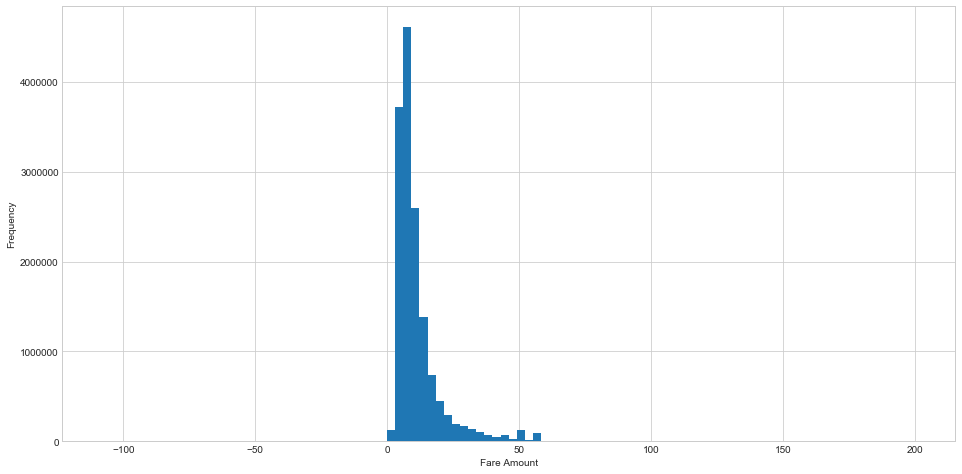

In [10]:
# Most the data are distributed below 200, so check again the data distribution below 200
train_df[train_df.fare_amount <200 ].fare_amount.hist(bins=100, figsize = (16,8))
plt.xlabel("Fare Amount")
plt.ylabel("Frequency")
# Boundary between 0 and 200 could be a good choice

In [11]:
train_df.quantile([0.02, 0.98])

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0.02,3.50,-74.010298,40.595953,-74.011904,40.577333,1.0
0.98,46.83,-73.137393,40.799855,-73.513109,40.810155,6.0


In [12]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.500000e+07,1.500000e+07,1.500000e+07,1.499990e+07,1.499990e+07,1.500000e+07
mean,1.133987e+01,-7.251155e+01,3.992075e+01,-7.251138e+01,3.991972e+01,1.685113e+00
std,9.797081e+00,1.296725e+01,9.295542e+00,1.289912e+01,9.404684e+00,1.325064e+00
min,-1.077500e+02,-3.439245e+03,-3.492264e+03,-3.426601e+03,-3.493652e+03,0.000000e+00
25%,6.000000e+00,-7.399208e+01,4.073491e+01,-7.399140e+01,4.073403e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075316e+01,1.000000e+00
75%,1.250000e+01,-7.396709e+01,4.076712e+01,-7.396368e+01,4.076809e+01,2.000000e+00
max,1.273310e+03,3.457626e+03,3.352849e+03,3.457622e+03,3.400392e+03,2.080000e+02


#### Notes on Data ####

Fare amount:
* Mean: 11.34
* Std: 9.82
* Min: -44.9 (There are some weird outliers with negative fares we'll have to remove)
* Max: 500 (We may have to remove a few of the extremely expensive fares, too)

Pickup/Dropoff Longitude:
* Mean: ~ -72.52
* Min: -3380 (Very much outliers we'll have to remove)
* Max: 2621 (see above)

Pickup/Dropoff Latitude:
* Mean: 39.9
* Min: -3115 (see above)
* Max: 1651 (see above)

Passenger Count:
* Min: 0 riders (may remove)
* Max: 208 riders (outlier)

It's worth noting from the quantile graph above that the 2nd to 98th percentile for each feature is rather close to the mean. All dropoff/pickup latitudes/longitudes seem reasonably close, passenger count is between 1 and 6, and fare is between 3.5 and 46.5. So while there are certainly some outliers we'll need to clean up, the dataset is generally clean. 

#### Data Cleaning ####

In [13]:
# Delete null value
print("old: %d" %len(train_df))
train_df = train_df.dropna(how = 'any', axis = 'rows')
print("new: %d" %len(train_df)) # track data amount before and after deletion

# Delete zero value
print("old: %d" %len(train_df))
train_df = train_df[~(train_df == 0).any(axis=1)]
print("new: %d" %len(train_df)) # track data amount before and after deletion

old: 15000000
new: 14999901
old: 14999901
new: 14649152


In [14]:
# Remove observations with useless values base on the test data boundary
mask = train_df['pickup_longitude'].between(-74.3, -72.9)
mask &= train_df['dropoff_longitude'].between(-74.3, -72.9)
mask &= train_df['pickup_latitude'].between(40.5, 41.8)
mask &= train_df['dropoff_latitude'].between(40.5, 41.7)
mask &= train_df['passenger_count'].between(0, 6)
mask &= train_df['fare_amount'].between(2, 200)


print("old: %d" %len(train_df))
train_df = train_df[mask]
print("new: %d" %len(train_df)) # track data amount before and after deletion

old: 14649152
new: 14628013


In [15]:
# Strip the 'pickup_datetime' column
def convert_to_datetime(df):
    df.pickup_datetime=pd.to_datetime(df.pickup_datetime,format='%Y-%m-%d %H:%M:%S UTC')
    return df 

# Apply to both train and test data   
train_df = convert_to_datetime(train_df)
test_df = convert_to_datetime(test_df)

# Chek shape
print (test_df.shape)
print (train_df.shape)

# Convert pickup_datetime to a DateTime object


(9914, 7)
(14628013, 8)


In [16]:
# Separate date data
def extract_date(data):
    
    data['pickup_date'] = data.pickup_datetime.dt.date
    data['pickup_day'] = data.pickup_datetime.dt.day
    data['pickup_hour'] = data.pickup_datetime.dt.hour
    data['pickup_day_of_week'] = data.pickup_datetime.dt.weekday
    data['pickup_month'] = data.pickup_datetime.dt.month
    data['pickup_year'] = data.pickup_datetime.dt.year
    data = data.drop(['pickup_datetime'], axis = 1)
    return data

# Apply to both train and test data      
train_df = extract_date(train_df)
test_df = extract_date(test_df)

# Chek shape
print (test_df.shape)
print (train_df.shape)

# Create datetime features based on pickup_datetime


(9914, 12)
(14628013, 13)


## Visualizing Data ##

In [17]:
# Map boundary boxes
BB= {
    'min_lng':-74.22,
    'min_lat':40.55,
    'max_lng':-73.65,
    'max_lat':41
}

BB_zoom = {
    'min_lng':-74.1,
    'min_lat':40.6,
    'max_lng':-73.7,
    'max_lat':40.9
}

BB_zoom_2 = {
    'min_lng':-74,
    'min_lat':40.7,
    'max_lng':-73.95,
    'max_lat':40.8
}

In [35]:
# Got these cool visualizations from a kernel on Kaggle: 
# https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration
# Using small datapoints, the streetgrid of New York becomes visible
def plot_res(df, BB, figsize=(12, 12), ax=None, c=('r', 'b'), s = 0.005, alpha = 0.5):
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    idx = boundary_box(df, BB)
    ax.scatter(df[idx].pickup_longitude, df[idx].pickup_latitude, c=c[0], s=s, alpha=alpha)
    ax.scatter(df[idx].dropoff_longitude, df[idx].dropoff_latitude, c=c[1], s=s, alpha=alpha)
    ax.legend(("Pickup Location (Red)", "Dropoff Location (Blue)"), loc='upper right', fontsize = 'large')
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    
# Eliminate samples with latitude/longitude coordinates outside NYC boundary
def boundary_box(df, BB):
    return (df.pickup_longitude >= BB['min_lng']) & (df.pickup_longitude <= BB['max_lng']) & \
           (df.pickup_latitude >= BB['min_lat']) & (df.pickup_latitude <= BB['max_lat']) & \
           (df.dropoff_longitude >= BB['min_lng']) & (df.dropoff_longitude <= BB['max_lng']) & \
           (df.dropoff_latitude >= BB['min_lat']) & (df.dropoff_latitude <= BB['max_lat'])

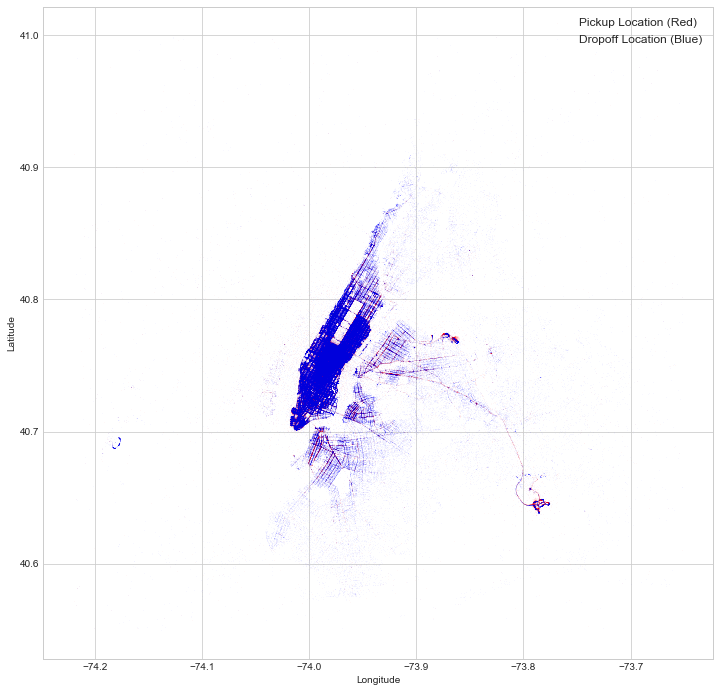

In [36]:
# Plot zoomed out
plot_res(train_df.head(1000000), BB, s = 0.001, alpha = 0.3)

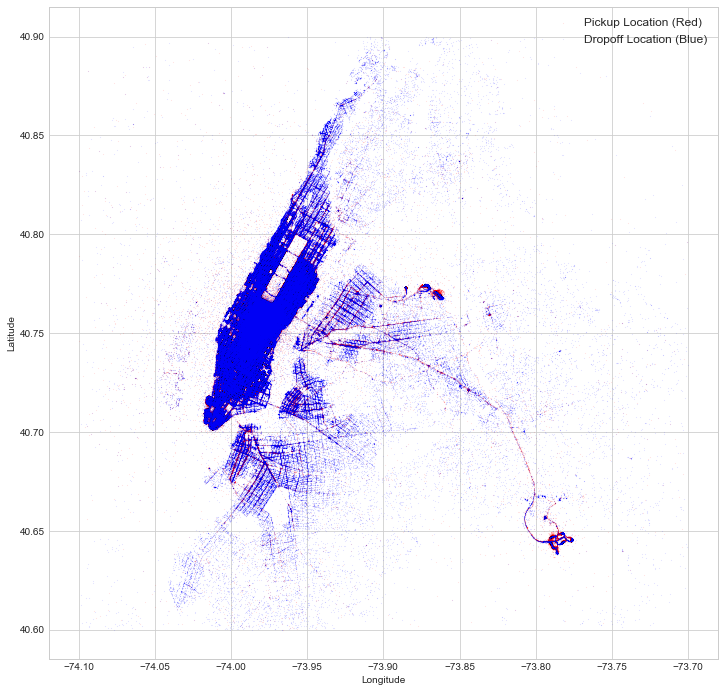

In [37]:
# First level zoom
plot_res(train_df.head(1000000), BB_zoom)

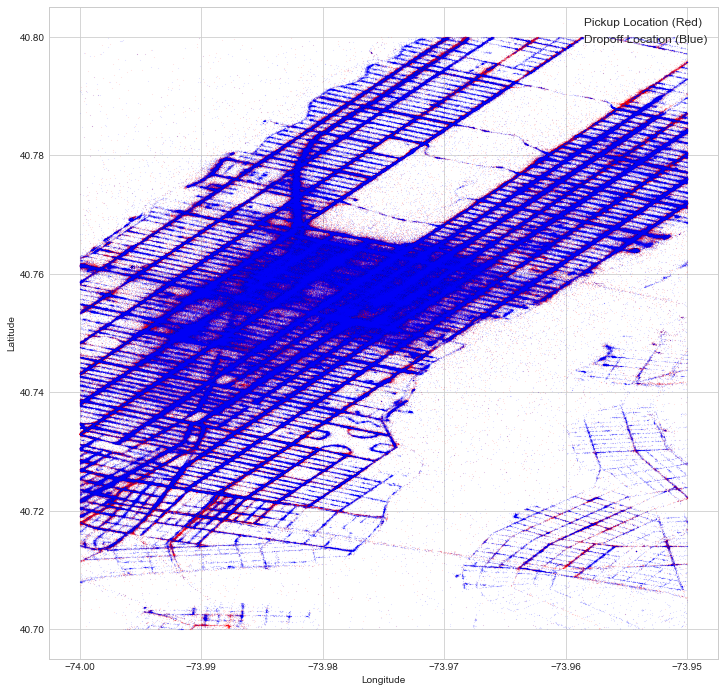

In [38]:
# Street-level zoom
plot_res(train_df.head(4000000), BB_zoom_2)

#### Interpreting Visualizations ####

We can tell several things from our visualizations of the data. The cab rides are distributed around New York City but concentrated in Manhattan. A fair number of pickup/dropoffs in Brooklyn and Queens, and few into / from the Bronx. There do seem to be a high density of trips that start/end at the three major New York Airports (JFK, LaGuardia, Newark), so we might want to look at that in more detail later on. 

## Feature Generation / Data Exploration ##

Several features to add:
    * add distance feature
    * add is_airport feature

### Distance: Use lat-lng to get distance ###

From the NYC taxi and limousine commission: http://www.nyc.gov/html/tlc/html/passenger/taxicab_rate.shtml

The initial charge is $2.50.
Plus 50 cents per 1/5 mile or 50 cents per 60 seconds in slow traffic or when the vehicle is stopped.
In moving traffic on Manhattan streets, the meter should “click” approximately every four downtown blocks, or one block going cross-town (East-West).
There is a 50-cent MTA State Surcharge for all trips that end in New York City or Nassau, Suffolk, Westchester, Rockland, Dutchess, Orange or Putnam Counties.
There is a 30-cent Improvement Surcharge. 
There is a daily 50-cent surcharge from 8pm to 6am.

Since the initial charge for every taxi ride in New York is 2.50 since 2012 (and 2.00 since earlier than our dataset starts recording), let's see how many samples have a fare at or below the $2.00 boundary.From the NYC taxi and limousine commission: http://www.nyc.gov/html/tlc/html/passenger/taxicab_rate.shtml

The initial charge is $2.50.
Plus 50 cents per 1/5 mile or 50 cents per 60 seconds in slow traffic or when the vehicle is stopped.
In moving traffic on Manhattan streets, the meter should “click” approximately every four downtown blocks, or one block going cross-town (East-West).
There is a 50-cent MTA State Surcharge for all trips that end in New York City or Nassau, Suffolk, Westchester, Rockland, Dutchess, Orange or Putnam Counties.
There is a 30-cent Improvement Surcharge. 
There is a daily 50-cent surcharge from 8pm to 6am.

Since the initial charge for every taxi ride in New York is 2.50 since 2012 (and 2.00 since earlier than our dataset starts recording), let's see how many samples have a fare at or below the $2.00 boundary.

In [16]:
def dist(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a)) 

In [17]:
def transform(data):
    # Distances to nearby airports, city center and other counties
    # By reporting distances to these points, the model can somewhat triangulate other locations of interest
    
    # city center (lng, lat)
    nyc = (-74.0060, 40.7128)
    
    # county (lng, lat)
    Nassau = (-73.5594, 40.6546)
    Suffolk = (-72.6151, 40.9849)
    Westchester = (-73.7949, 41.1220)
    Rockland = (-73.9830, 41.1489)
    Dutchess = (-73.7478, 41.7784)
    Orange = (-74.3118, 41.3912)
    Putnam = (-73.7949, 41.4351) 

    # airport
    jfk = (-73.7781, 40.6413)
    ewr = (-74.1745, 40.6895)
    lgr = (-73.8740, 40.7769)
    
    
    # county
    data['pickup_distance_to_center'] = dist(nyc[1], nyc[0],
                                      data.pickup_latitude, data.pickup_longitude)
    data['dropoff_distance_to_center'] = dist(nyc[1], nyc[0],
                                      data.pickup_latitude, data.pickup_longitude)
    
    data['pickup_distance_to_Nassau'] = dist(Nassau[1], Nassau[0],
                                      data.pickup_latitude, data.pickup_longitude)
    data['dropoff_distance_to_Nassau'] = dist(Nassau[1], Nassau[0],
                                      data.pickup_latitude, data.pickup_longitude.)
    
    data['pickup_distance_to_Suffolk'] = dist(Suffolk[1], Suffolk[0],
                                      data.pickup_latitude., data.pickup_longitude.)
    data['dropoff_distance_to_Suffolk'] = dist(Suffolk[1], Suffolk[0],
                                      data.pickup_latitude, data.pickup_longitude)
    
    data['pickup_distance_to_Westchester'] = dist(Westchester[1], Westchester[0],
                                      data.pickup_latitude, data.pickup_longitude)
    data['dropoff_distance_to_Westchester'] = dist(Westchester[1], Westchester[0],
                                      data.pickup_latitude, data.pickup_longitude)
    
    data['pickup_distance_to_Rockland'] = dist(Rockland[1], Rockland[0],
                                      data.pickup_latitude, data.pickup_longitude)
    data['dropoff_distance_to_Rockland'] = dist(Rockland[1], Rockland[0],
                                      data.pickup_latitude, data.pickup_longitude)
    
    data['pickup_distance_to_Dutchess'] = dist(Dutchess[1], Dutchess[0],
                                      data.pickup_latitude, data.pickup_longitude)
    data['dropoff_distance_to_Dutchess'] = dist(Dutchess[1], Dutchess[0],
                                      data.pickup_latitude, data.pickup_longitude)
    
    data['pickup_distance_to_Orange'] = dist(Orange[1], Orange[0],
                                      data.pickup_latitude, data.pickup_longitude)
    data['dropoff_distance_to_Orange'] = dist(Orange[1], Orange[0],
                                      data.pickup_latitude, data.pickup_longitude)
    
    data['pickup_distance_to_Putnam'] = dist(Putnam[1], Putnam[0],
                                      data.pickup_latitude, data.pickup_longitude)
    data['dropoff_distance_to_Putnam'] = dist(Putnam[1], Putnam[0],
                                      data.pickup_latitude, data.pickup_longitude)
    
    # airports
    data['pickup_distance_to_jfk'] = dist(jfk[1], jfk[0],
                                         data.pickup_latitude, data.pickup_longitude)
    data['dropoff_distance_to_jfk'] = dist(jfk[1], jfk[0],
                                           data.pickup_latitude, data.pickup_longitude)
    
    data['pickup_distance_to_ewr'] = dist(ewr[1], ewr[0], 
                                          data.pickup_latitude, data.pickup_longitude)
    data['dropoff_distance_to_ewr'] = dist(ewr[1], ewr[0],
                                           data.pickup_latitude, data.pickup_longitude)
    
    data['pickup_distance_to_lgr'] = dist(lgr[1], lgr[0],
                                          data.pickup_latitude, data.pickup_longitude)
    data['dropoff_distance_to_lgr'] = dist(lgr[1], lgr[0],
                                           data.pickup_latitude, data.pickup_longitude)
    
    # point distance
    data['distance'] = dist(data.pickup_latitude, data.pickup_longitude,
                            data.dropoff_latitude, data.dropoff_longitude)
    
    return data

In [18]:
train_df = transform(train_df)
test_df = transform(test_df)

# Chek shape
print (test_df.shape)
print (train_df.shape)


(9914, 35)
(14628013, 36)


In [19]:
# Consider extra charges
def convert(df):

    df['county_dropoff'] = np.where((df.pickup_distance_to_center <= 5) &
                                     ((df.dropoff_distance_to_Nassau <= 21.3) |
                                      (df.dropoff_distance_to_Westchester <= 22.4) |
                                      (df.dropoff_distance_to_Suffolk <= 48.7) |           
                                      (df.dropoff_distance_to_Rockland <= 14.1) |
                                      (df.dropoff_distance_to_Dutchess <= 28.7) |
                                      (df.dropoff_distance_to_Orange <= 29) |
                                      (df.dropoff_distance_to_Putnam <= 15.7)), 1, 0)
    
    # 50-cent surcharge from 8pm to 6am.
    df['night_hour'] = np.where((df.pickup_hour >= 20) |
                                (df.pickup_hour <= 6) , 1, 0)
    
    # $1 surcharge from 4pm to 8pm on weekdays, excluding holidays.
    df['peak_hour'] = np.where((df.pickup_hour >= 16) &
                                (df.pickup_hour <= 20) & 
                                (df.pickup_day_of_week >=0) &
                                (df.pickup_day_of_week <=4) , 1, 0)
    
    # Flat fare of $52 plus tolls, the 50-cent MTA State Surcharge, the 30-cent Improvement Surcharge, 
    # to and from JFK and any location in Manhattan:
    df['to_from_jfk'] = np.where(((df.pickup_distance_to_jfk <= 2) & (df.dropoff_distance_to_center <= 5)) | 
                                 ((df.pickup_distance_to_center <= 5) & (df.dropoff_distance_to_jfk <= 2)) ,1, 0)

    # $4.50 rush hour surcharge (4 PM to 8 PM weekdays, excluding legal holidays). to  and from JFK and any location in Manhattan:
    df['jfk_rush_hour'] = np.where((df.to_from_jfk == 1) & 
                                   (df.pickup_hour >= 16) &
                                   (df.pickup_hour <= 20) ,1, 0)
    
    # $17.50 Newark Surcharge to Newark Airport:
    df['ewr'] = np.where((df.pickup_distance_to_center <= 5) &
                         (df.dropoff_distance_to_ewr <= 1) ,1, 0)
    
    return df

In [20]:
# Apply to both train and test data      
train_df = convert(train_df)
test_df = convert(test_df)

print (test_df.shape)
print (train_df.shape)

(9914, 41)
(14628013, 42)


#### Re-trim train data to reflect test data ```distance``` range ####

In [21]:
test_df.distance.describe()

count    9914.000000
mean        2.134640
std         2.468319
min         0.000000
25%         0.806712
50%         1.377836
75%         2.513634
max        62.134660
Name: distance, dtype: float64

In [22]:
train_df.distance.describe()

count    1.462801e+07
mean     2.067536e+00
std      2.339915e+00
min      0.000000e+00
25%      7.790564e-01
50%      1.337888e+00
75%      2.429708e+00
max      8.937474e+01
Name: distance, dtype: float64

In [23]:
mask_2 = train_df['distance'].between(0, 65)

In [24]:
print("old: %d" %len(train_df))
train_df = train_df[mask_2]
print("new: %d" %len(train_df)) # track data amount before and after deletion

old: 14628013
new: 14627950


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Distribution of Trip Distance')

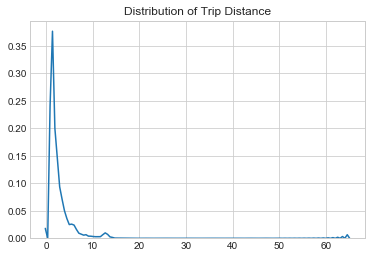

In [25]:
# Graph of trip distances
sns.kdeplot(train_df['distance'].values).set_title("Distribution of Trip Distance")

#### Log-transform ```trip_distance``` ####

In [26]:
# Log transform trip distance to improve distribution for modeling.

def log_transform(df):
    df['log_distance'] = np.log(df.distance + 1)  # Account for division by zero
    return df

In [27]:
train_df = log_transform(train_df)
test_df = log_transform(test_df)

print(train_df.shape)
print(test_df.shape)

(14627950, 43)
(9914, 42)


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Distribution of Trip Distance')

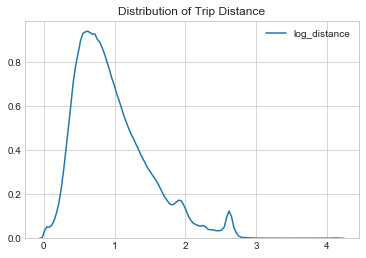

In [28]:
# Graph of trip distances (log scale)
sns.kdeplot(train_df.log_distance).set_title("Distribution of Trip Distance")

In [29]:
corr_test = train_df.head(5000000)

In [30]:
print(train_df.shape)
train_df = train_df.drop(['pickup_date', 'key'], axis = 1)
print(train_df.shape)
train_df.dtypes

(14627950, 43)
(14627950, 41)


fare_amount                        float64
pickup_longitude                   float64
pickup_latitude                    float64
dropoff_longitude                  float64
dropoff_latitude                   float64
passenger_count                      int64
pickup_day                           int64
pickup_hour                          int64
pickup_day_of_week                   int64
pickup_month                         int64
pickup_year                          int64
pickup_distance_to_center          float64
dropoff_distance_to_center         float64
pickup_distance_to_Nassau          float64
dropoff_distance_to_Nassau         float64
pickup_distance_to_Suffolk         float64
dropoff_distance_to_Suffolk        float64
pickup_distance_to_Westchester     float64
dropoff_distance_to_Westchester    float64
pickup_distance_to_Rockland        float64
dropoff_distance_to_Rockland       float64
pickup_distance_to_Dutchess        float64
dropoff_distance_to_Dutchess       float64
pickup_dist

In [31]:
# Check column names
print(train_df.columns)
# Check corr of 'fare_amount' to all the other variables
print(train_df.corrwith(corr_test['fare_amount']))

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'pickup_day', 'pickup_hour', 'pickup_day_of_week', 'pickup_month',
       'pickup_year', 'pickup_distance_to_center',
       'dropoff_distance_to_center', 'pickup_distance_to_Nassau',
       'dropoff_distance_to_Nassau', 'pickup_distance_to_Suffolk',
       'dropoff_distance_to_Suffolk', 'pickup_distance_to_Westchester',
       'dropoff_distance_to_Westchester', 'pickup_distance_to_Rockland',
       'dropoff_distance_to_Rockland', 'pickup_distance_to_Dutchess',
       'dropoff_distance_to_Dutchess', 'pickup_distance_to_Orange',
       'dropoff_distance_to_Orange', 'pickup_distance_to_Putnam',
       'dropoff_distance_to_Putnam', 'pickup_distance_to_jfk',
       'dropoff_distance_to_jfk', 'pickup_distance_to_ewr',
       'dropoff_distance_to_ewr', 'pickup_distance_to_lgr',
       'dropoff_distance_to_lgr', 'distance', 'county_dropoff', 'night_hour',
    

Drop ```passenger_count```, ```pickup_day```, ```pickup_hour```, ```pickup_day_of_week```, ```pickup_month```, ```pickup_distance_to_lgr```, ```dropoff_distance_to_lgr```, ```county_dropoff_1```, ```county_dropoff_2```, ```county_dropoff```

In [34]:
# We can choose to remove the variables that has the corr less than 0.1
train_df = train_df.drop(['passenger_count','pickup_hour','pickup_day','pickup_month','pickup_day_of_week', 'pickup_distance_to_lgr',
                         'dropoff_distance_to_lgr', 'county_dropoff'], axis = 1)
test_df = test_df.drop(['passenger_count','pickup_hour','pickup_day','pickup_month','pickup_day_of_week', 'pickup_distance_to_lgr',
                         'dropoff_distance_to_lgr', 'county_dropoff'], axis = 1)

# Chek shape
print (test_df.shape)
print (train_df.shape)

(9914, 34)
(14627950, 33)


In [41]:
train_df.to_csv("all/train_cleaned.csv", index = False)

In [42]:
test_df.to_csv("all/test_cleaned.csv", index = False)

In [38]:
train_df.head(5)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_year,pickup_distance_to_center,dropoff_distance_to_center,pickup_distance_to_Nassau,dropoff_distance_to_Nassau,...,dropoff_distance_to_jfk,pickup_distance_to_ewr,dropoff_distance_to_ewr,distance,night_hour,peak_hour,to_from_jfk,jfk_rush_hour,ewr,log_distance
0,4.5,-73.844311,40.721319,-73.841610,40.712278,2009,8.487860,8.487860,15.622516,15.622516,...,6.527098,17.433727,17.433727,0.640487,0,1,0,0,0,0.494993
1,16.9,-74.016048,40.711303,-73.979268,40.782004,2010,0.536308,0.536308,24.244875,24.244875,...,13.373879,8.435586,8.435586,5.250670,0,1,0,0,0,1.832689
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2011,3.563510,3.563510,23.365466,23.365466,...,13.550258,11.198778,11.198778,0.863411,1,0,0,0,0,0.622409
3,7.7,-73.987130,40.733143,-73.991567,40.758092,2012,1.718130,1.718130,23.055184,23.055184,...,12.657169,10.266000,10.266000,1.739386,1,0,0,0,0,1.007734
4,5.3,-73.968095,40.768008,-73.956655,40.783762,2010,4.299771,4.299771,22.793770,22.793770,...,13.254398,12.092157,12.092157,1.242218,0,0,0,0,0,0.807466


On to modeling notebook

## Model Selection ##

Based on the evaluation of several machine learning algorithms, we will continue with the GBR. While the training time is high, we need not worry about making predictions in real time, and the RMSE is far lower for the GBR model than the 
others. Another option would be to use a Ridge Regression, but we will stick with GBR (and possibly an LGBR) for now.

In [325]:
import lightgbm as lgbm
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': 4,
        'num_leaves': 31,
        'learning_rate': 0.05,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,
        'num_rounds':50000
    }


def LGBMmodel(X_train,X_test,y_train,y_test,params):
    matrix_train = lgbm.Dataset(X_train, y_train)
    matrix_test = lgbm.Dataset(X_test, y_test)
    model=lgbm.train(params=params,
                    train_set=matrix_train,
                    num_boost_round=100000, 
                    early_stopping_rounds=500,
                    verbose_eval=100,
                    valid_sets=matrix_test)
    return model

In [326]:
model = LGBMmodel(train_X,val_X,train_y,val_y,params)

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:111: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds.
[100]	valid_0's rmse: 3.85593
[200]	valid_0's rmse: 3.74626
[300]	valid_0's rmse: 3.72937
[400]	valid_0's rmse: 3.72465
[500]	valid_0's rmse: 3.72179
[600]	valid_0's rmse: 3.72102
[700]	valid_0's rmse: 3.72082
[800]	valid_0's rmse: 3.72047
[900]	valid_0's rmse: 3.72145
[1000]	valid_0's rmse: 3.72223
[1100]	valid_0's rmse: 3.72291
[1200]	valid_0's rmse: 3.72377
Early stopping, best iteration is:
[765]	valid_0's rmse: 3.72003
